In [1]:
using Gen
using PyPlot
using Revise
include("../src/utils.jl")
include("../src/model.jl");

# Collisions

Being able to model collisions is a crucial element of commonsense physical understanding.

### Random Normals

We can build a model of random normals, that approximate the surfaces of obstacles in the environment.

These normals reflect the component of velocity anti-parallel to them, with a certain `restitution` denoting the elasticity of the collision.

In our simple case, we don't try to model the presence of normals using the identity of other objects or their shapes.

Instead, in a prior we consider each surface to be a either a vertical wall, or uniformly distributed, very massive line segment that our test object may collide with.

In [2]:
struct CollisionHypers
    accel_std :: Real
    obs_std :: Real
    prob_collision :: Real
    restitution :: Real
    prob_vertical_wall :: Real
end

"""
Samples a random acceleration with possible collisions.
With probability `prob_collision`, sample a normal vector and reflect the component of velocity perpendicular to it, with magnitude proportional to `restitution`.
The normal vector is horizontal with probability `prob_vertical_wall`, and is otherwise uniformly randomly sampled.
With probability `1 - prob_collision`, sample a gaussian centered at zero with `accel_std`.
"""
@gen function collision_dynamics_randomness(prev_state::State, accel_std::Real, prob_collision::Real, restitution::Real, prob_vertical_wall::Real)
    if (has_collision ~ bernoulli(prob_collision))
        # collision dynamics
        vel = prev_state.velocity

        if (has_vertical_wall ~ bernoulli(prob_vertical_wall))
            normal_angle = 0.
        else
            normal_angle ~ uniform(0, 2π)
        end
        ndir = (cos(normal_angle), sin(normal_angle))

        # reflect the velocity
        reflected_a = -ndir * dot(vel, ndir) * (1 + restitution)
        rand_ax ~ normal(reflected_a[1], accel_std)
        rand_ay ~ normal(reflected_a[2], accel_std)
    else
        # inertial dynamics
        rand_ax ~ normal(0, accel_std)
        rand_ay ~ normal(0, accel_std)
    end
    return (rand_ax, rand_ay)
end

"""
Models the trajectory of a particle across `T` time steps, starting at `init_state`, possibly with collisions.
The particle is subject to `const_a`, plus a tiny gaussian distributed acceleration centered at zero with `accel_std`, and a possible collision.
The end position is then observed.
"""
@gen function collision_dynamics_model(T::Int, init_state::State, const_a::Vec2, hypers::CollisionHypers)
    # initialization
    states = Vector{State}(undef, T+1)
    states[1] = init_state

    # run dynamics
    for t in 1:T
        # model randomness
        rand_a = {t} ~ collision_dynamics_randomness(states[t], hypers.accel_std,
                                                                hypers.prob_collision,
                                                                hypers.restitution,
                                                                hypers.prob_vertical_wall)

        # run simulation
        states[t+1] = dynamics_sim(states[t], rand_a; const_a=const_a)
    end

    # object emerges
    final_pos = states[end].position
    {:obs} ~ obs_randomness(final_pos, hypers.obs_std)

    return states
end;


### Hitting a wall

Let's simulatie our tossing situation from the gravity notebook, this time with the possiblity of collisions.

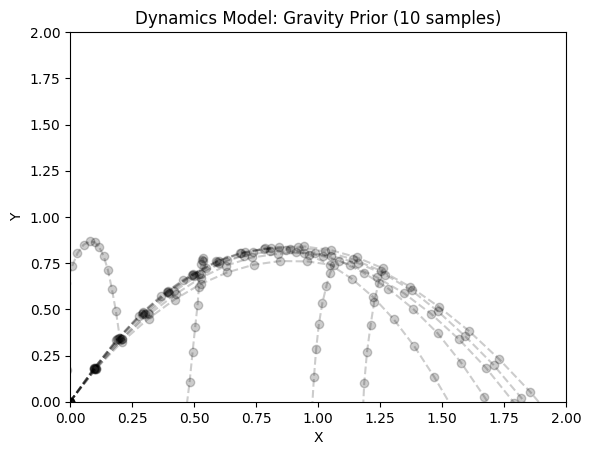

In [3]:
# model args
T = 18
toss_to_right = State((0,0), (0.1, 0.2), (0,0))
gravity_accel = (0, -0.022)
hypers = CollisionHypers(0.0025, 0.02, 0.05, 0.15, 0.9)  # σ_accel, σ_obs, prob_collision, restitution, prob_vertical_wall
model_args = (T, toss_to_right, gravity_accel, hypers)

# set plotting parameters
init_toss_plot(obs, subtitle) = init_occluder_scene(obs, subtitle;
        plot_bounds=(xmin=0,ymin=0,xmax=2.0,ymax=2.0),
        occluder_bounds=(xmin=0,ymin=0,xmax=0.2,ymax=1))

# plot tossed object
num_traces_to_visualize = 10
fig, ax = init_toss_plot(nothing, "Gravity Prior ($num_traces_to_visualize samples)")
prior_traces = [first(Gen.generate(collision_dynamics_model, model_args)) for _ in 1:num_traces_to_visualize]
(tr -> draw_trace!(ax, tr)).(prior_traces);

As we can see, sometimes the object bounces off of an unseen surface.

If we observe the object to hit the ground at a relatively close point, even with a uniform prior over the presence of normal forces, we can infer a the object hits a consistent obstacle at a consistent time, that may represent a wall or heavy obstacle.

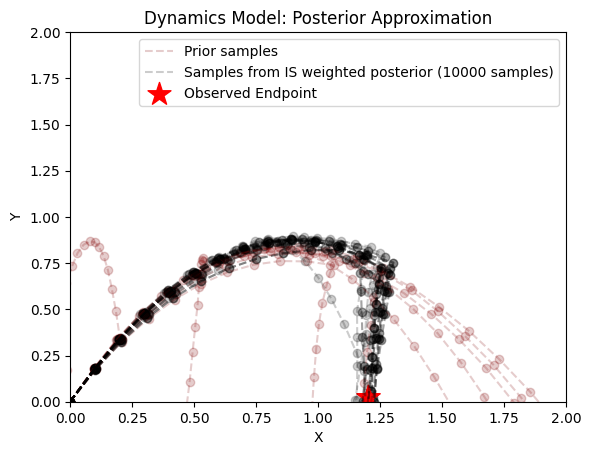

In [4]:
# observed end point
obs_x = 1.2
obs_y = 0.025
constraints = Gen.choicemap()
constraints[:obs => :x] = obs_x
constraints[:obs => :y] = obs_y

# importance sampling
num_traces_to_visualize = 25
num_is_samples = 10000
fig2, ax = init_toss_plot((obs_x, obs_y), "Posterior Approximation")
(post_traces, log_norm_weights, lml_est) = importance_sampling(collision_dynamics_model, model_args, constraints, num_is_samples)
probs = exp.(log_norm_weights)
lines, = (tr -> draw_trace!(ax, tr; color="maroon")).(prior_traces)
lines[end].set_label("Prior samples")
lines, = (tr -> draw_trace!(ax, tr; color="black")).(post_traces[[categorical(probs) for _ in 1:num_traces_to_visualize]])
lines[end].set_label("Samples from IS weighted posterior ($num_is_samples samples)")
ax.legend()
ax.scatter(obs_x, obs_y, s=300, marker="*", c="red", label="Observed Endpoint");